In [1]:
import ujson
import pprint
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from operator import itemgetter
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# For displaying google maps
import gmplot
from IPython.display import IFrame

# For summary stats
import scipy
from scipy import stats

# For testing a subset of the data
from copy import deepcopy

pp = pprint.PrettyPrinter(indent=4)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Testing auto adding time output to all cells
'''
#To install...
wget https://raw.githubusercontent.com/cpcloud/ipython-autotime/master/autotime.py
#Make available via
jupyter nbextension install /Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/autotime.py
'''
 
%load_ext autotime

In [3]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')


time: 22.3 ms


# Working with data already parsed from LoadData - 1 notebook
## Load parsed data

In [61]:
#time: 12min 44s
# Full dataset
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed.json"
# Partial dataset
#_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_10k.json"
# Partial dataset, outliers removed
_file = "/Users/patrickmulrooney/Downloads/endomondoHR/endoHRParsed_no_outliers_10k.json"

endoHR = []

with open(_file, 'r') as f:
    endoHR += ujson.load(f)

time: 8.96 s


In [62]:
print "Length of import: %s"%(len(endoHR))

Length of import: 10000
time: 1.7 ms


In [63]:
## Used between cells

# List of all the exercise types in the dataset
exercise_types = {}

# Keys in each record
all_keys = []


series_keys = { True: ['timestamp', 'heart_rate', 'altitude', 'latitude', 'longitude', 'speed' ], \
               False: ['timestamp', 'heart_rate', 'altitude', 'latitude', 'longitude'] }

time: 5.64 ms


In [64]:
# See what keys still remain.
sports = {}
count = 0
for _endoHR in endoHR:
    all_keys += _endoHR.keys()
    _sport = _endoHR[ 'sport' ]
    try:
        sports[_sport] += 1
    except:
        sports[_sport] = 1
        
    if _sport not in exercise_types.keys():
        exercise_types[_sport] = count
        count += 1

# Drop dupes
all_keys = set( all_keys )

sports2 = []

for k,v in sports.iteritems():
    sports2.append((k,v))

print "What keys remain?"
pp.pprint( all_keys )

print ""
print ""

print "What sports?"
pp.pprint( sorted(sports2, key=itemgetter(1), reverse=True) )

What keys remain?
set([   u'gender',
        u'id',
        u'series',
        u'speed_included',
        u'sport',
        u'url',
        u'userId'])


What sports?
[   (u'run', 4273),
    (u'bike', 3866),
    (u'bike (transport)', 1056),
    (u'mountain bike', 535),
    (u'orienteering', 111),
    (u'kayaking', 59),
    (u'indoor cycling', 34),
    (u'rowing', 30),
    (u'core stability training', 12),
    (u'walk', 10),
    (u'hiking', 6),
    (u'weight training', 3),
    (u'skate', 1),
    (u'tennis', 1),
    (u'cross-country skiing', 1),
    (u'stair climing', 1),
    (u'elliptical', 1)]
time: 63 ms


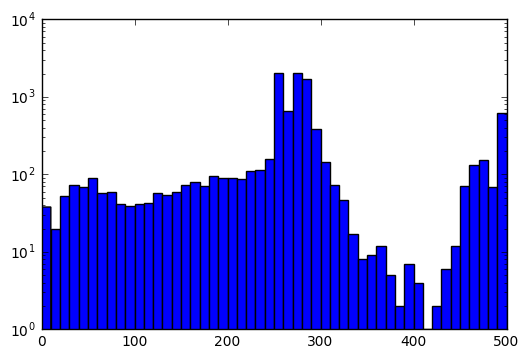

time: 4.61 s


In [65]:
seriesLength = []

for _endoHR in log_progress(endoHR, every=5):

    # For debugging purposes, get a record of length of series for histogram
    _seriesLen = len(_endoHR['series'])
    seriesLength.append(_seriesLen)
    
plt.hist(seriesLength, bins=50, log=True)
plt.show()

### Notes
Looks like there must be some sort of limit with the HR stuff of 500 records per exercise, or the api not returning more than that. Need to look at this further.

### Get deltas of timestamps and speed in series. 


In [66]:

for _endoHR in log_progress(endoHR, every=1):
    _max_time_delta = 0
    
    _timestamps = [item[0] for item in _endoHR['series']]
    _endoHR['end_start_delta'] = max(_timestamps) - min(_timestamps)

    for i,_cur in enumerate(_timestamps[:-2]):
        _next = _timestamps[i+1]
        _diff = _next - _cur
        if _diff > _max_time_delta:
            _max_time_delta = _diff
    
    _endoHR['max_time_delta'] = _max_time_delta
    
    if _endoHR['speed_included']:
        _max_speed_delta = 0
        _max_speed = 0
        
        _speeds = [item[5] for item in _endoHR['series']]

        for i,_cur in enumerate(_speeds[:-2]):
            _next = _speeds[i+1]
            _diff = _next - _cur
            
            if _diff > _max_speed_delta:
                _max_speed_delta = _diff
                
            if _cur > _max_speed:
                _max_speed = _cur
    
        _endoHR['max_speed'] = _max_speed
        _endoHR['max_speed_delta'] = _max_speed_delta


ValueError: max() arg is an empty sequence

time: 1.99 s


In [ ]:
# See how long 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

_esd = sorted([(item['end_start_delta']/60) for item in endoHR])

print pd.Series(_esd).describe()

# Based on summary stats, lets only keep those less than 6 hours. Beyond that is crazy.
_esd = [_i for _i in _esd if _i < 360]

plt.hist(_esd,bins=50)
plt.show()

## Figure out where these people are.

In [11]:
#time: 9min 12s
lat_longs = []

for _endoHR in log_progress(endoHR, every=1):
    _series = _endoHR['series'][0]
    lat_longs.append([_series[3], _series[4], _endoHR['sport']])

time: 20 s


In [12]:
#time: 7.94 s
# Write the lat longs to file, need to figure out how to map. Probably google maps and kml, try basemap below.

target = open("/Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/lat_longs.txt", 'w')
for i in lat_longs:
    target.write("%s,%s\n"%(i[0],i[1]))
    
target.close()

time: 29.2 ms


In [13]:
lats = [ _i[0] for _i in lat_longs ]
lons = [ _i[1] for _i in lat_longs ]
sport_type = [ exercise_types[_i[2]] for _i in lat_longs ]

time: 20.8 ms


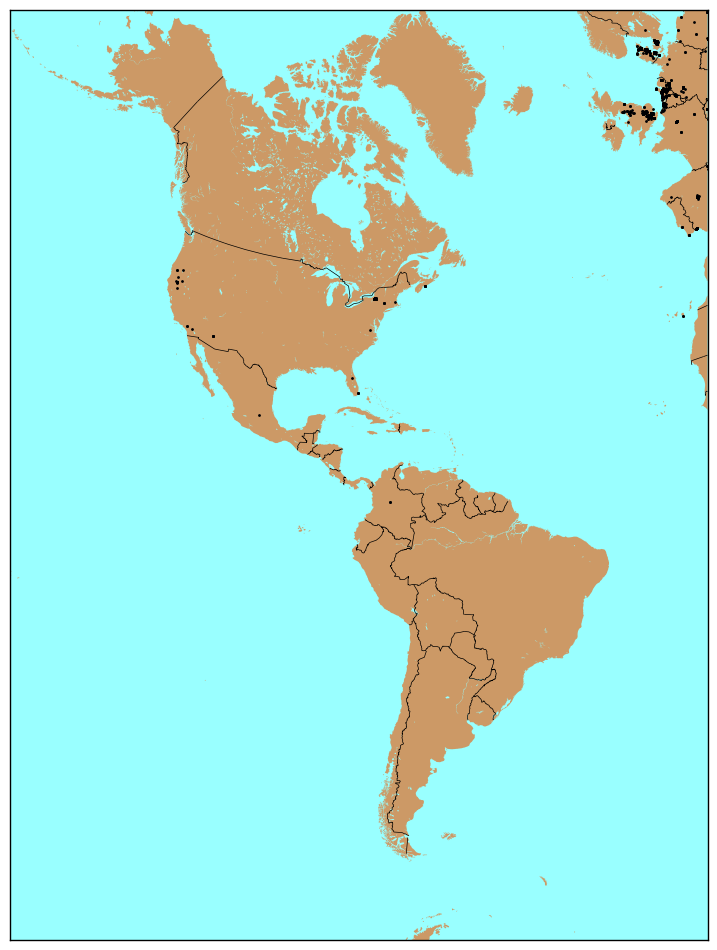

time: 28.1 s


In [14]:
# Americas
plt.figure(figsize=(12,12))
m = Basemap(width=15000000,height=20000000,resolution='i',projection='stere', lat_ts=0,lat_0=10,lon_0=-80.)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

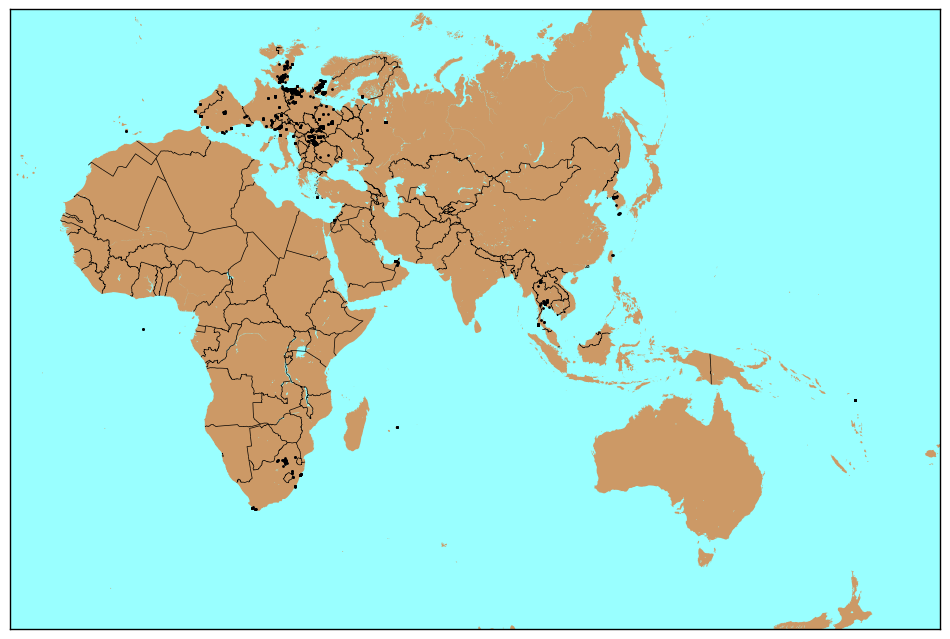

time: 28.6 s


In [15]:
# Europe, Africa, Asia, etc
plt.figure(figsize=(12,12))
m = Basemap(width=30000000,height=20000000,resolution='i',projection='stere', lat_ts=0,lat_0=10,lon_0=80.)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

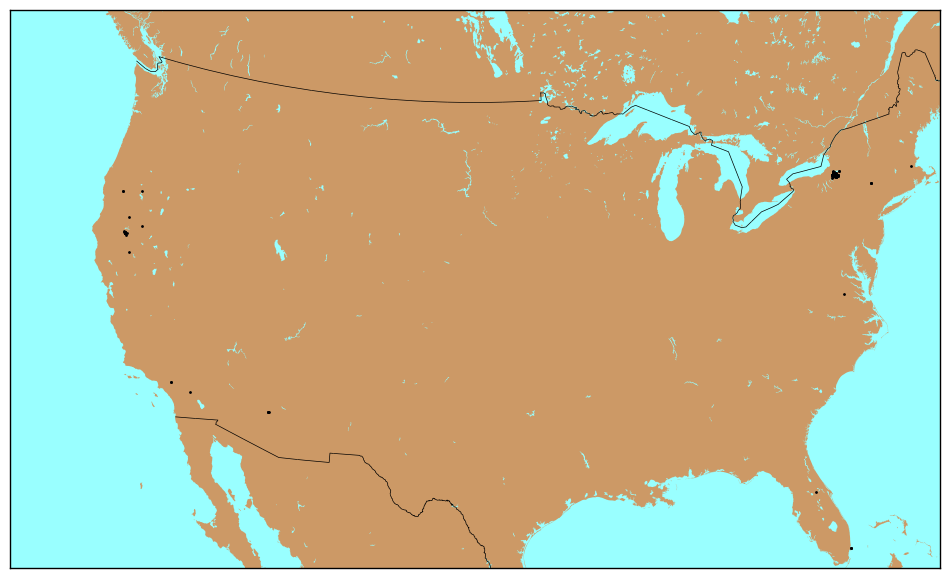

time: 22.3 s


In [16]:
#US
lat=40
lon=-100

plt.figure(figsize=(12,12))
m = Basemap(width=5000000,height=3000000,resolution='h',projection='stere', lat_ts=0,lat_0=lat,lon_0=lon)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

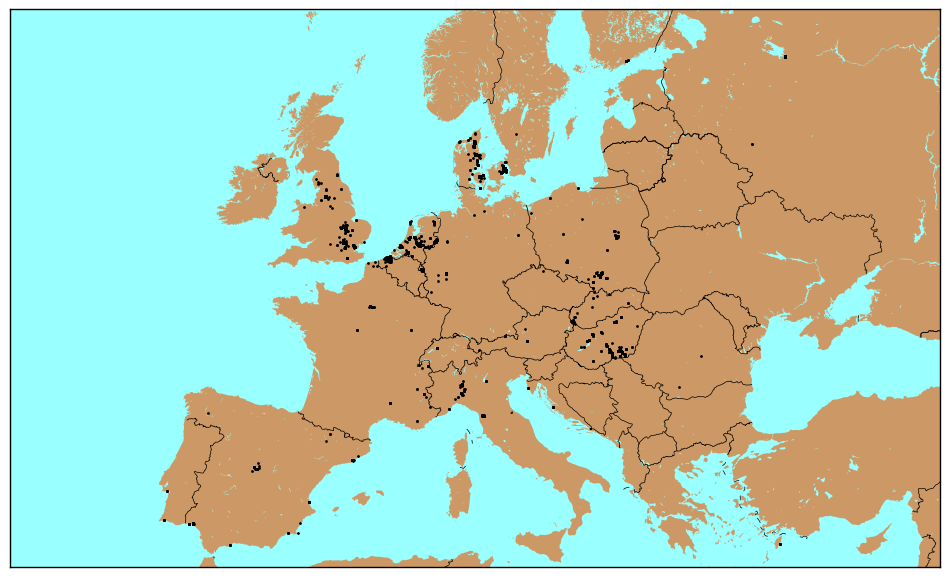

time: 31 s


In [17]:
#Europe
lat=50
lon=10

plt.figure(figsize=(12,12))
m = Basemap(width=5000000,height=3000000,resolution='h',projection='stere', lat_ts=0,lat_0=lat,lon_0=lon)
x, y = m(lons,lats)
m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
m.scatter(x,y,1, marker='o')
m.drawcountries()
plt.show()

In [18]:

lats_rounded = [ float("{0:.4f}".format(_i)) for _i in lats ]
lons_rounded = [ float("{0:.4f}".format(_i)) for _i in lons ]
sport_type = [ exercise_types[_i[2]] for _i in lat_longs ]

# declare the center of the map, and how much we want the map zoomed in
gmap = gmplot.GoogleMapPlotter(0, 0, 2)
# plot heatmap
gmap.heatmap(lats_rounded, lons_rounded)

gmap.draw("/Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/workout_heatmap.html")


time: 64.2 ms


In [19]:
# Need to add api key to script line 
IFrame('workout_heatmap.html', width=700, height=350)

time: 4.07 ms


#### Notes
* Really popular in Copenhagen. Endomundo was founded in Copenhagen.
* Really popular in Bangkok. No idea why

## Figure out who works out the most, and how much

In [20]:
#time: 9min 51s
_uid_freq = {}
for _endoHR in log_progress(endoHR, every=5):
    try:
        _uid_freq[_endoHR['userId']] += 1
    except:
        _uid_freq[_endoHR['userId']] = 1
        
_uid_freq2 = []

for k,v in _uid_freq.iteritems():
    _uid_freq2.append((k,v))

print "Top 100 users"
pp.pprint( sorted(_uid_freq2, key=itemgetter(1), reverse=True)[:100] )

Top 100 users
[   (4997910, 1013),
    (14066832, 894),
    (196571, 637),
    (13693003, 530),
    (8467445, 523),
    (10057948, 487),
    (4007546, 453),
    (1655221, 442),
    (3327597, 437),
    (5325166, 377),
    (885462, 355),
    (982359, 349),
    (3060590, 319),
    (16786, 306),
    (2104631, 292),
    (13279851, 266),
    (1543833, 240),
    (430859, 228),
    (3905196, 182),
    (732008, 166),
    (6539051, 163),
    (4969375, 150),
    (4419649, 139),
    (338866, 125),
    (1517642, 111),
    (9815069, 102),
    (854368, 97),
    (279317, 90),
    (22260, 90),
    (7898832, 75),
    (519257, 66),
    (11889307, 49),
    (903587, 47),
    (3083777, 36),
    (6361870, 33),
    (10921915, 31),
    (6299290, 29),
    (897592, 28),
    (15279967, 27),
    (5337796, 7),
    (6479229, 5),
    (6481880, 2),
    (13110384, 2)]
time: 4.23 s


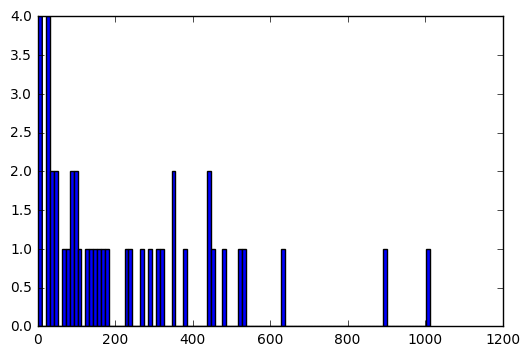

time: 417 ms


In [21]:
plt.hist(sorted([_i[1] for _i in _uid_freq2]),bins=100)
plt.show()

### What sports did the top 100 most active users do?

In [22]:
#time: 9min 51s
_top_participants = [ _i[0] for _i in sorted(_uid_freq2, key=itemgetter(1), reverse=True)[:100]]

_uid_freq_detail = {}
for _endoHR in log_progress(endoHR, every=1):
    if not _endoHR['userId'] in _uid_freq_detail.keys():
        _uid_freq_detail[_endoHR['userId']] = {}
    if _endoHR['sport'] in _uid_freq_detail[_endoHR['userId']].keys():
        _uid_freq_detail[_endoHR['userId']][_endoHR['sport']] += 1
    else:
        _uid_freq_detail[_endoHR['userId']][_endoHR['sport']] = 1
        
_uid_freq_detail2 = []

for k,v in _uid_freq_detail.iteritems():
    _uid_freq_detail2.append((k,v))

sorted(_uid_freq_detail2, key=lambda x: sum(x[1].values()) , reverse=True)[:100]

[(4997910, {u'bike': 2, u'bike (transport)': 856, u'mountain bike': 155}),
 (14066832, {u'bike': 844, u'indoor cycling': 1, u'run': 49}),
 (196571, {u'bike': 11, u'orienteering': 100, u'run': 526}),
 (13693003,
  {u'bike': 322,
   u'bike (transport)': 48,
   u'core stability training': 2,
   u'run': 153,
   u'walk': 5}),
 (8467445, {u'bike': 444, u'indoor cycling': 3, u'run': 76}),
 (10057948, {u'bike': 449, u'bike (transport)': 2, u'hiking': 2, u'run': 34}),
 (4007546, {u'run': 450, u'walk': 3}),
 (1655221,
  {u'bike': 82,
   u'bike (transport)': 2,
   u'core stability training': 4,
   u'hiking': 1,
   u'indoor cycling': 1,
   u'mountain bike': 72,
   u'run': 280}),
 (3327597, {u'bike': 340, u'bike (transport)': 1, u'mountain bike': 96}),
 (5325166,
  {u'bike': 204, u'indoor cycling': 2, u'mountain bike': 4, u'run': 167}),
 (885462, {u'bike': 1, u'run': 354}),
 (982359,
  {u'bike': 72,
   u'bike (transport)': 71,
   u'elliptical': 1,
   u'indoor cycling': 26,
   u'mountain bike': 141,

time: 18.5 s


In [23]:
# Lets figure out where user 4997910 lives / works.
# So many bike commutes probably will be able top guess based on heat map

_user = []

for _i in endoHR:
    if _i['userId'] == 4997910:
        _user.append(_i['series'])


time: 11 ms


In [24]:
_user = [ item for sublist in _user for item in sublist]

time: 54.6 ms


In [25]:
print len(_user)
_user[:10]

505571


[[1449233966, 67, 1742.0, -26.18858, 28.005362],
 [1449233970, 68, 1742.0, -26.188575, 28.005357],
 [1449233975, 69, 1742.0, -26.188574, 28.005356],
 [1449233980, 71, 1742.0, -26.188557, 28.005337],
 [1449233985, 71, 1744.0, -26.188565, 28.005339],
 [1449233990, 74, 1744.0, -26.188543, 28.005317],
 [1449233995, 83, 1744.0, -26.188483, 28.005268],
 [1449234000, 83, 1744.0, -26.188447, 28.005058],
 [1449234005, 82, 1744.0, -26.188361, 28.004933],
 [1449234010, 85, 1744.0, -26.187991, 28.005018]]

time: 5.36 ms


In [26]:
_user_lat = [_i[3] for _i in _user]
_user_long = [_i[4] for _i in _user]

time: 164 ms


In [27]:
gmap = gmplot.GoogleMapPlotter(0, 0, 2)
# plot heatmap
gmap.heatmap(_user_lat, _user_long)

gmap.draw("/Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/user_tracking/workout_heatmap_4991910.html")

IOError: [Errno 2] No such file or directory: '/Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/user_tracking/workout_heatmap_4991910.html'

time: 423 ms


### Was able to determine where this user likely lives, and where they likely work

### Lets try the top 5 users

In [28]:

_top_users = [ _j[0] for _j  in sorted(_uid_freq_detail2, key=lambda x: sum(x[1].values()) , reverse=True)[:10]]

for _j in log_progress(_top_users):
    _user = []
    for _i in endoHR:
        if _i['userId'] == _j:
            _user.append(_i['series'])

    # Flatten
    _user = [ item for sublist in _user for item in sublist]
    _user_lat = [_i[3] for _i in _user]
    _user_long = [_i[4] for _i in _user]

    gmap = gmplot.GoogleMapPlotter(0, 0, 2)
    # plot heatmap
    #gmap.heatmap(_user_lat, _user_long)
    # map markers
    #gmap.scatter(_user_lat, _user_long, '#3B0B39', size=40, marker=False)
    gmap.scatter(_user_lat, _user_long, 'k', marker=True)
    # Not sure..
    #gmap.plot(_user_lat, _user_long, 'cornflowerblue', edge_width=10)


    gmap.draw("/Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/user_tracking/workout_heatmap_%s.html"%_j)

IOError: [Errno 2] No such file or directory: '/Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/user_tracking/workout_heatmap_4997910.html'

time: 943 ms


## Lets get summary stats of series time

In [29]:
endoHR_stats = []

for _endoHR in log_progress(endoHR, every=1):
    _summary = { 'average_diff': 0, 'median_diff': [], 'delta': 0, }
    
    _timestamps = [item[0] for item in _endoHR['series']]
    
    # only concern ourselves with those more than 60 timestamps in the activity.
    if len(_timestamps) < 60:
        continue
    
    _summary['delta'] = _timestamps[-1] - _timestamps[0]
    
    
    for _i, _timestamp in enumerate(_timestamps[:-2]):
        _diff = _timestamps[_i+1] - _timestamps[_i]
        _summary['average_diff'] += _diff
        _summary['median_diff'].append(_diff)
        
    try:
        _summary['average_diff'] = _summary['average_diff'] / len(_timestamps)
        _summary['median_diff'] = sorted(_summary['median_diff'])[len(_timestamps)/2]
    except:
        print len(_timestamps)
    endoHR_stats.append(_summary)
    


time: 24.4 s


In [30]:
endoHR_stats
print "Average"
print scipy.stats.describe([_i['average_diff'] for _i in endoHR_stats])

print ""
print "Median"
print scipy.stats.describe([_i['median_diff'] for _i in endoHR_stats])


Average
DescribeResult(nobs=9879, minmax=(-45, 620546), mean=114.9480716671728, variance=50208299.214857332, skewness=78.11682919096985, kurtosis=6418.362429225661)

Median
DescribeResult(nobs=9879, minmax=(1, 71), mean=9.3150116408543369, variance=56.23523828443625, skewness=2.2748426816845955, kurtosis=6.875441006380736)
time: 12.4 ms


## Heartrate analysis

In [31]:
_heart_rates = [ item[1] for sublist in endoHR for item in sublist['series']]

time: 473 ms


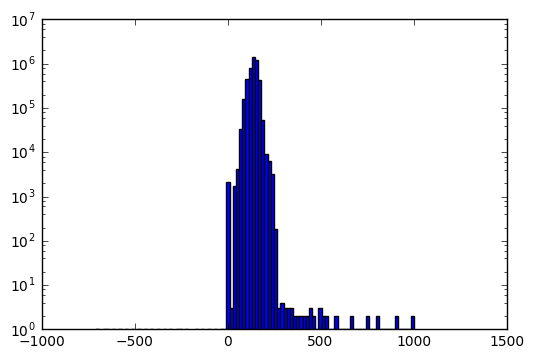

time: 2.34 s


In [32]:
plt.hist(sorted(_heart_rates),bins=100, log=True)
plt.show()

In [33]:
# heart rate summary stats
print scipy.stats.describe(_heart_rates)

DescribeResult(nobs=4588116, minmax=(-706, 1001), mean=138.85998130823197, variance=535.43734211369917, skewness=-0.28498873914121653, kurtosis=8.590392462446449)
time: 517 ms


#### Looks like there is a fair amount of garbage in the heart rate data. Min = -706, Max = 1001. Lets set some limits.

from: https://www.reddit.com/r/askscience/comments/1opolp/what_is_the_fastest_the_average_human_heart_could/

```
The absolute refractory period of cardiac muscle is between 250 and 300 ms. That means cardiac contractions are physiologically limited to 200-240 beats per minute.
```

#### So lets set a max of 250 and min of 40. Below that likely to be error.

In [34]:
_bad_heart_rates = [ _i for _i in _heart_rates if _i not in range(40,250)]
_heart_rates = [ _i for _i in _heart_rates if _i in range(40,250)]

time: 25.1 s


In [35]:
print scipy.stats.describe(_heart_rates)

DescribeResult(nobs=4584431, minmax=(40, 249), mean=138.94515807959593, variance=518.26159385119036, skewness=-0.29719615089194534, kurtosis=0.5384869234569667)
time: 503 ms


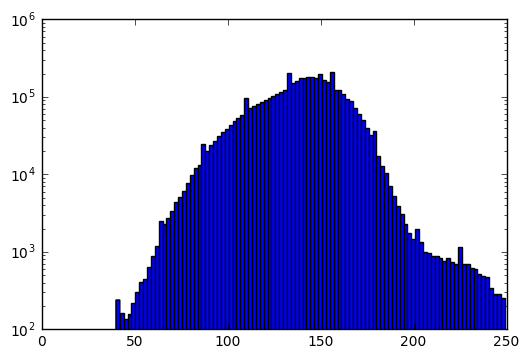

time: 2.21 s


In [36]:
plt.hist(sorted(_heart_rates),bins=100, log=True)
plt.show()

#### Bad heart rate numbers

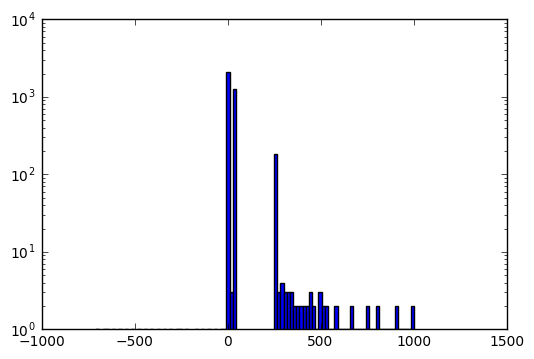

time: 675 ms


In [37]:
plt.hist(sorted(_bad_heart_rates),bins=100, log=True)
plt.show()

## Speed analysis

In [38]:
_speed = [ item[5] for sublist in endoHR for item in sublist['series'] if sublist['speed_included'] == True]

time: 1.27 s


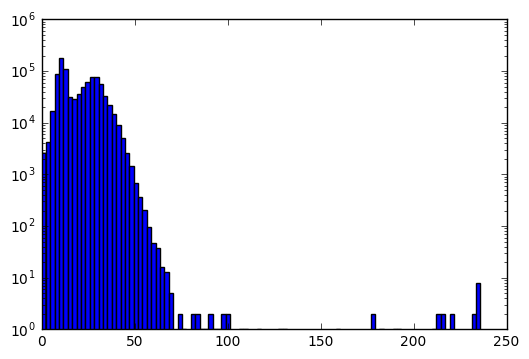

time: 1.94 s


In [39]:
plt.hist(sorted(_speed),bins=100, log=True)
plt.show()

In [40]:
print scipy.stats.describe(_speed)

DescribeResult(nobs=906767, minmax=(0.0, 235.904), mean=19.899747931578126, variance=99.43029698870474, skewness=0.6384432316761095, kurtosis=3.2101317603820165)
time: 137 ms


#### No speed below zero, but seems unlikely someone got up to 235 MPH (assuming it is MPH, need to check. 235KM/h is just as unlikely). Lets look at it by sport 

------
skate
0
------
kayaking
6948


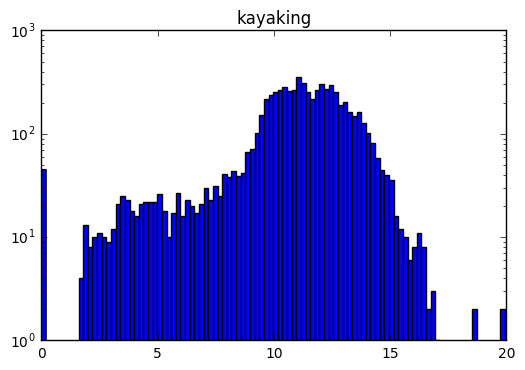

------
run
362580


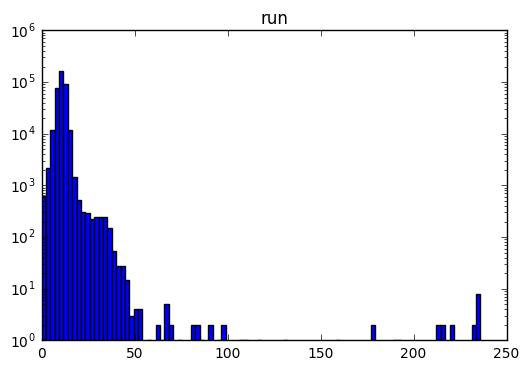

------
orienteering
1060


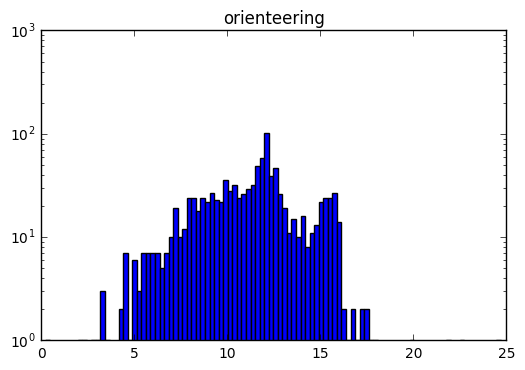

------
hiking
20


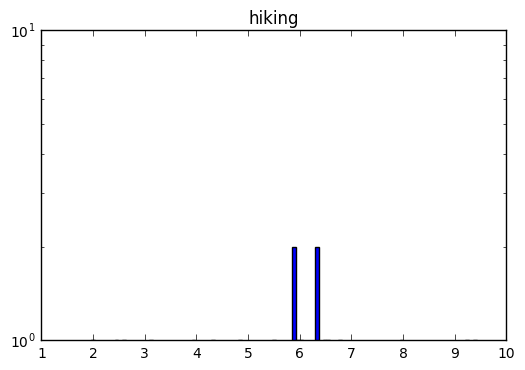

------
rowing
4898


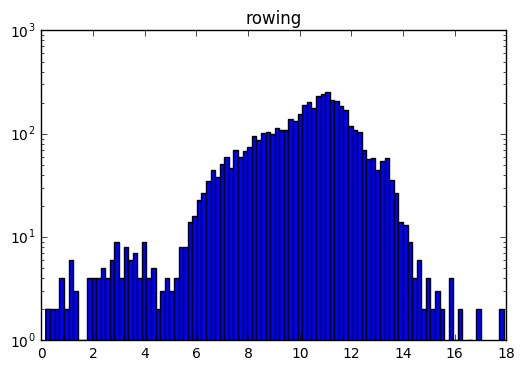

------
tennis
0
------
walk
80


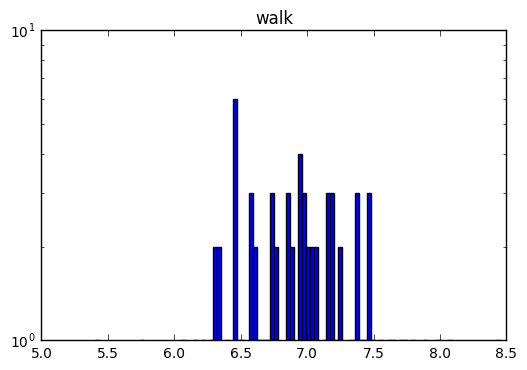

------
cross-country skiing
0
------
bike
486977


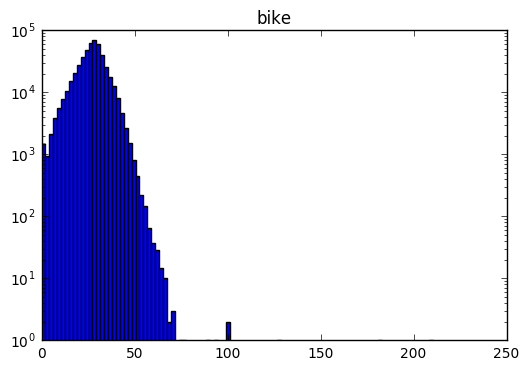

------
stair climing
12


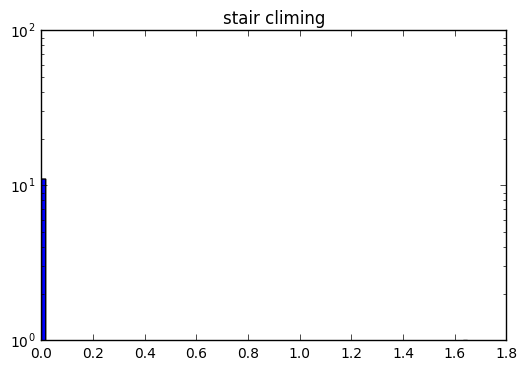

------
elliptical
0
------
indoor cycling
6216


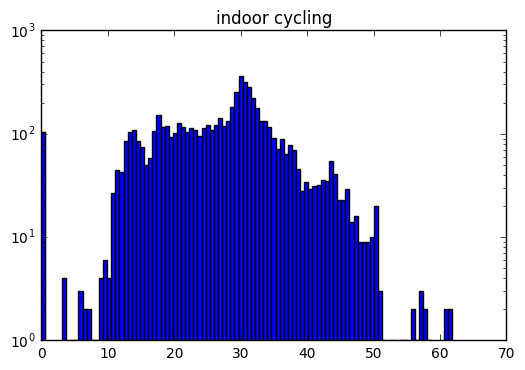

------
mountain bike
25027


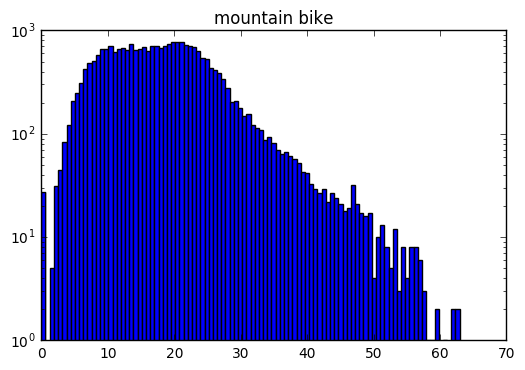

------
bike (transport)
12828


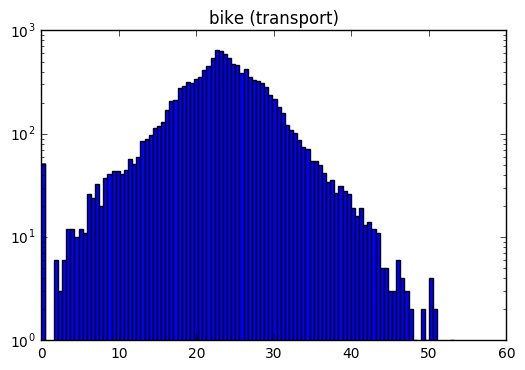

------
core stability training
121


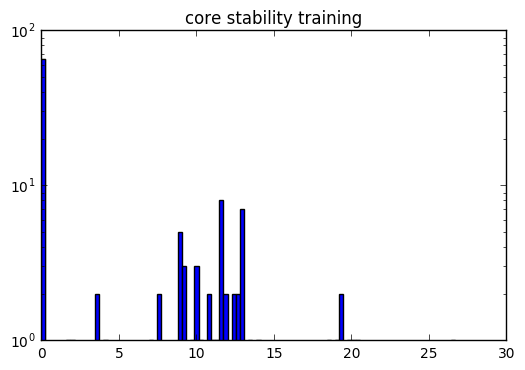

------
weight training
0
time: 34 s


In [41]:
for _i in exercise_types.keys():
    _speed = [ item[5] for sublist in endoHR for item in sublist['series'] if sublist['speed_included'] == True and sublist['sport'] == _i]
    print "------"
    print _i
    print len(_speed)
    if len(_speed) == 0:
        continue
    plt.hist(sorted(_speed),bins=100, log=True)
    plt.title(_i)
    plt.show()

### Altitude

In [42]:
_altitude = [ item[2] for sublist in endoHR for item in sublist['series'] ]

time: 784 ms


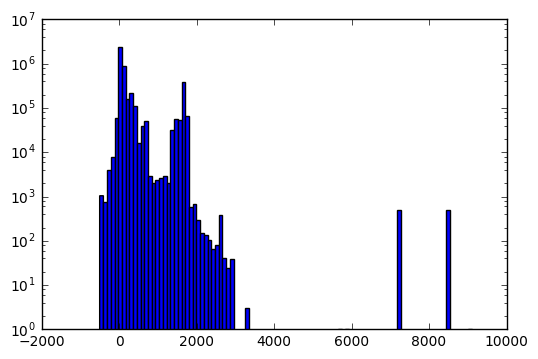

time: 3.38 s


In [43]:
plt.hist(sorted(_altitude),bins=100, log=True)
plt.show()

In [44]:
print scipy.stats.describe(_altitude)

DescribeResult(nobs=4588116, minmax=(-500.0, 9105.6000000000004), mean=295.2359939098028, variance=298036.39489707671, skewness=2.448600535134866, kurtosis=10.261544548289447)
time: 546 ms


In [45]:
_high_altitude_locations = [item[3:5] for sublist in endoHR for item in sublist['series'] if item[2] > 5000]

time: 677 ms


In [46]:
# declare the center of the map, and how much we want the map zoomed in
gmap = gmplot.GoogleMapPlotter(0, 0, 2)
# plot heatmap
gmap.scatter([_i[0] for _i in _high_altitude_locations ],[_i[1] for _i in _high_altitude_locations ])

gmap.draw("/Users/patrickmulrooney/class/notebooks/pjmulroo/DSECapstone/high_altitude_workout_locations.html")


time: 20.8 ms


In [47]:
for _i in endoHR:
    if len([1 for item in _i['series'] if item[2] > 5000]) > 0:
        print _i['gender'], _i['id'], _i['sport'], _i['url'], _i['userId']

male 227890083 bike https://www.endomondo.com/users/8467445/workouts/227890083 8467445
male 378773782 run https://www.endomondo.com/users/1655221/workouts/378773782 1655221
male 374792411 run https://www.endomondo.com/users/1655221/workouts/374792411 1655221
male 374792746 bike https://www.endomondo.com/users/1655221/workouts/374792746 1655221
time: 876 ms


## Sanity check latitude and longitude

#### Values should only between -90 / 90 & -180 / 180

In [59]:
_latitude = [ item[3] for sublist in endoHR for item in sublist['series'] ]
_longitude = [ item[4] for sublist in endoHR for item in sublist['series'] ]

print scipy.stats.describe(_latitude)
print scipy.stats.describe(_longitude)

DescribeResult(nobs=2483464, minmax=(-34.410733999999998, 60.385443018700002), mean=32.165394918621928, variance=926.42847264817476, skewness=-1.148041268009289, kurtosis=-0.3798922343378175)
DescribeResult(nobs=2483464, minmax=(-160.00089, 166.95938899999999), mean=17.16221429666172, variance=1565.928270310525, skewness=0.29392526102433597, kurtosis=3.1333985783880216)
time: 1.53 s


#### Looks good